# Practice Assignment 1 - Task 1
Detect fat cells in a digital histopathology image of a skin biopsy.

# Image Enhancement
We'll split the input image into the three channels, so we can determine which channel has the best contrast.

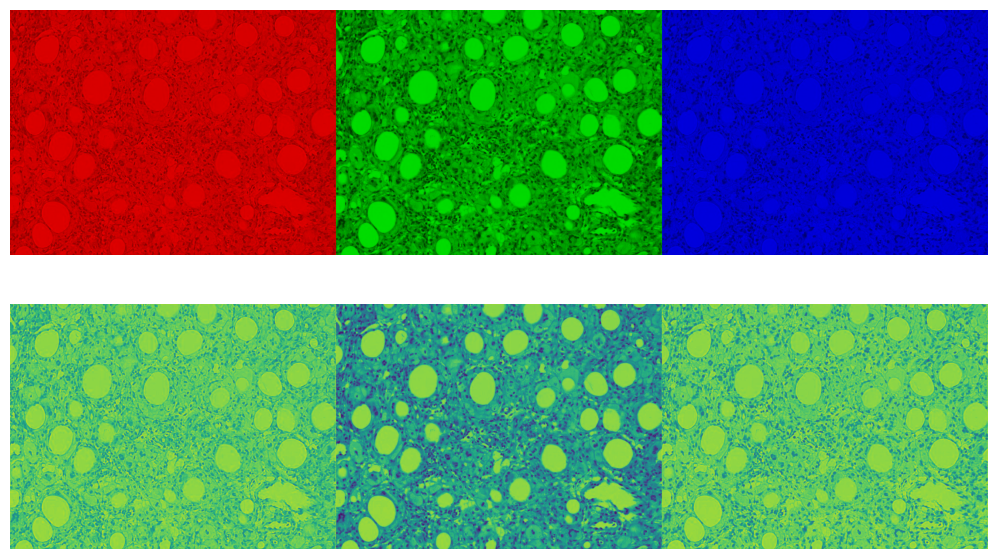

In [96]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 7.0]

img = cv.imread("task1.jpg")
b, g, r = cv.split(img)

zeros = np.zeros(img.shape[:2], dtype="uint8")

img_red = cv.merge([zeros, zeros, r])
img_green = cv.merge([zeros, g, zeros])
img_blue = cv.merge([b, zeros, zeros])

all_img_rgb = np.hstack((img_blue, img_green, img_red))
all_img_gray = np.hstack((b, g, r))

plt.subplot(211)
plt.axis('off')
plt.imshow(all_img_rgb)
plt.subplot(212)
plt.axis('off')
plt.imshow(all_img_gray)

# 1.2 Image Enhancement
We will enhance the image by converting it to grayscale, then applying histogram equalization to increase contrast.

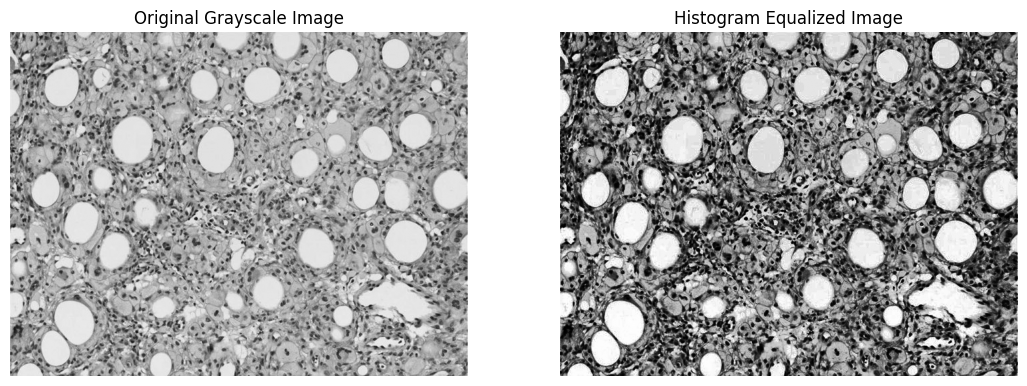

In [97]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_hist_eq = cv.equalizeHist(img_gray)

plt.subplot(121)
plt.axis('off')
plt.title("Original Grayscale Image")
plt.imshow(img_gray, cmap="gray")

plt.subplot(122)
plt.axis('off')
plt.title("Histogram Equalized Image")
plt.imshow(img_gray_hist_eq, cmap="gray")


# 1.3 Thresholding
We will apply different types of thresholding to the equalized image so we can see which one is best for our purposes.

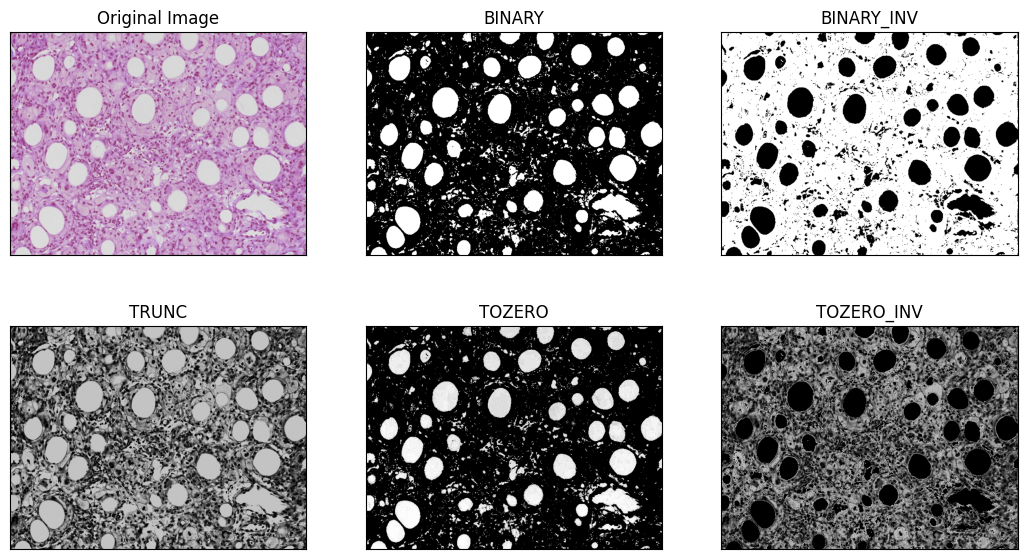

In [98]:
thresh_val = 195
max_val = 255
ret, img_bin = cv.threshold(img_gray_hist_eq, thresh_val, max_val, cv.THRESH_BINARY)
ret, img_bin_inv = cv.threshold(img_gray_hist_eq, thresh_val, max_val, cv.THRESH_BINARY_INV)
ret, img_bin_trunc = cv.threshold(img_gray_hist_eq, thresh_val, max_val, cv.THRESH_TRUNC)
ret, img_bin_tozero = cv.threshold(img_gray_hist_eq, thresh_val, max_val, cv.THRESH_TOZERO)
ret, img_bin_tozero_inv = cv.threshold(img_gray_hist_eq, thresh_val, max_val, cv.THRESH_TOZERO_INV)

titles = ['Original Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']

images = [img, img_bin, img_bin_inv, img_bin_trunc, img_bin_tozero, img_bin_tozero_inv]

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], 'gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

# 1.4 Noise Removal
We will use image eroding to get rid of the noise. We will use the binary inverted image.

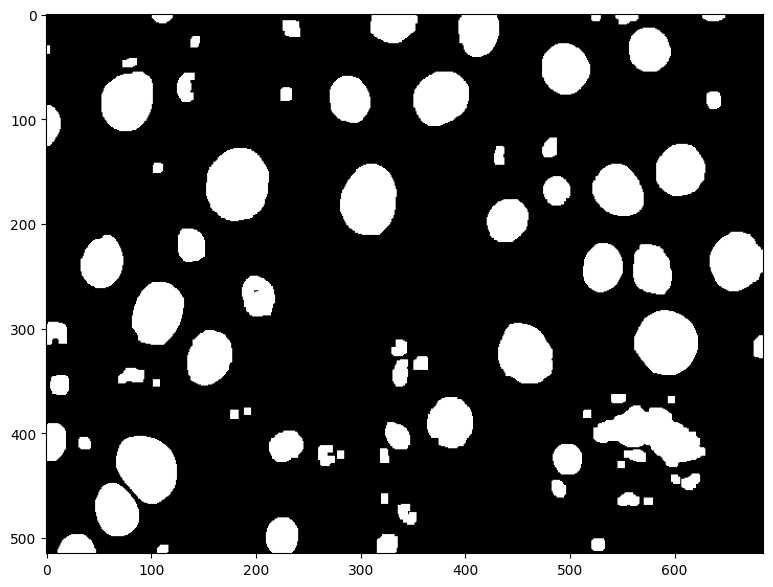

In [99]:
chosen_img = img_bin
erosion_size = 2
dilation_size = 3

element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2*erosion_size+1, 2*erosion_size+1), (erosion_size, erosion_size))

img_eroded = cv.erode(chosen_img, element)

dilation_shape = cv.MORPH_RECT

element = cv.getStructuringElement(dilation_shape, (2*dilation_size+1, 2*dilation_size+1), (dilation_size, dilation_size))
img_dilation = cv.dilate(chosen_img, element)

kernel = np.ones((7,7),np.uint8)
closing = cv.morphologyEx(chosen_img, cv.MORPH_OPEN, kernel)
plt.imshow(closing, cmap="gray")

# 1.5 Extraction of Binary Regions of Interest / Connected Components


(np.float64(-0.5), np.float64(684.5), np.float64(514.5), np.float64(-0.5))

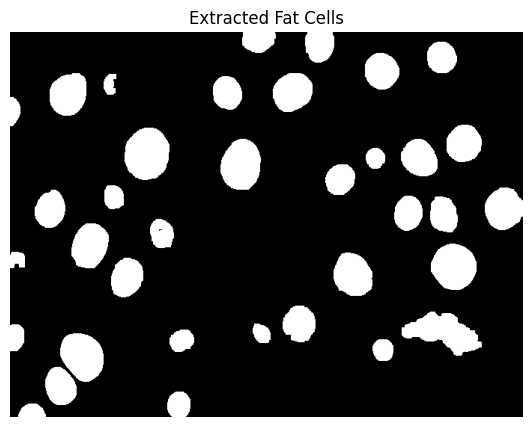

In [100]:
num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(closing, connectivity=8)

min_fat_cell_area = 350 # pixels - may need to adjust

fat_cells_mask = np.zeros_like(closing)

for label in range(1, num_labels):
  area = stats[label, cv.CC_STAT_AREA]

  if area >= min_fat_cell_area:
    fat_cells_mask[labels_im == label] = 255

# Display result
plt.figure(figsize=(15, 5))
plt.imshow(fat_cells_mask, cmap='gray')
plt.title('Extracted Fat Cells')
plt.axis('off')

# 1.6 Filtering of Fat Globules
Filter out regions which are not globule-like and do not potentially represent fat. You can use the properties of area, compactness, eccentricity to filter out non-globule regions. Find suitable properties and values to perform filtering. You can do it in several steps as per your choice and analysis.

Mention the region properties and their values you have selected for filtering and include the resulting images after filtering regions based on each property. Also include the total number of fat globules you have left at this point.

Advanced filtering: 26 cells extracted


(np.float64(-0.5), np.float64(684.5), np.float64(514.5), np.float64(-0.5))

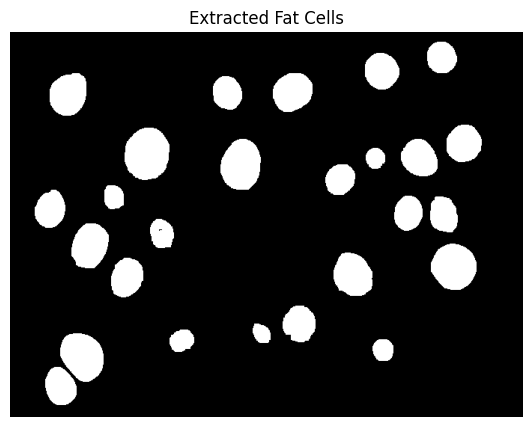

In [101]:
# Redo above but with more advanced filtering
extracted_count_advanced = 0
max_fat_cell_area = 5000  # Add maximum area to exclude large dead cells
border_margin = 5  # Distance from edge to exclude cut-off cells
img_height, img_width = closing.shape

fat_cells_mask_advanced = np.zeros_like(closing)

total_area = 0

for label in range(1, num_labels):
  component_max = (labels_im == label).astype(np.uint8) * 255

  contours, _ = cv.findContours(component_max, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  if len(contours) > 0:
    contour = contours[0]
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)

    # Calculate circularity (4π * area / perimeter^2)
    # Perfect circle = 1, lower values = more irregular
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    # Basic stats
    x = stats[label, cv.CC_STAT_LEFT]
    y = stats[label, cv.CC_STAT_TOP]
    width = stats[label, cv.CC_STAT_WIDTH]
    height = stats[label, cv.CC_STAT_HEIGHT]

    # Border check
    touching_border = (x <= border_margin or 
                          y <= border_margin or 
                          x + width >= img_width - border_margin or 
                          y + height >= img_height - border_margin)
    
    # Advanced filtering criteria
    if (area >= min_fat_cell_area and area <= max_fat_cell_area and circularity >= 0.5 and not touching_border):
      fat_cells_mask_advanced[labels_im == label] = 255
      extracted_count_advanced += 1
      total_area += area

print(f"Advanced filtering: {extracted_count_advanced} cells extracted")
# Display result
plt.figure(figsize=(15, 5))
plt.imshow(fat_cells_mask_advanced, cmap='gray')
plt.title('Extracted Fat Cells')
plt.axis('off')

# 1.7 Calculation of the fat area

In [107]:
print(f"Total fat area: {total_area}")
print(f"Percentage of fat in image: {(total_area / (img_height * img_width) * 100):.2f}%")

Total fat area: 42800.5
Percentage of fat in image: 12.13%
